In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.decomposition import PCA

In [ ]:
SEED = 42
SUBSET_SIZE = 15000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
RESIZE_DIM = 128
LATENT_DIM = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
BETA_KL = 1.0

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Using {SUBSET_SIZE if SUBSET_SIZE else 'all'} images.")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Batch size: {BATCH_SIZE}")

data_path = '/kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5'
print(f"Full data path: {data_path}")

Using device: cuda
Using 15000 images.
Latent dimension: 128
Batch size: 64
Full data path: /kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5


This cell handles loading the jet image data (X_jets) from the HDF5 file. The raw data (N, Height, Width, Channels), is converted to a PyTorch tensor and permuted to the (N, Channels, Height, Width) format. Images are resized to a uniform RESIZE_DIM. It also calculates the mean and standard deviation only on the training portion of the data to prevent data leakage from the validation set. These statistics are then used to normalize the entire dataset.

In [ ]:
print(f"Loading data from: {data_path}")
with h5py.File(data_path, 'r') as f:
    print("Keys in dataset:", list(f.keys()))
    if SUBSET_SIZE:
        X_jets_raw = f['X_jets'][:SUBSET_SIZE]
    else:
        X_jets_raw = f['X_jets'][:]
    print(f"Loaded raw X_jets shape: {X_jets_raw.shape}") # expected (N, 125, 125, 3)

X_jets_tensor = torch.tensor(X_jets_raw, dtype=torch.float32).permute(0, 3, 1, 2)
del X_jets_raw

if X_jets_tensor.shape[-2:] != (RESIZE_DIM, RESIZE_DIM):
    print(f"Resizing images to {RESIZE_DIM}x{RESIZE_DIM}...")
    X_jets_resized = F.interpolate(X_jets_tensor, size=(RESIZE_DIM, RESIZE_DIM), mode='bilinear', align_corners=False)
else:
    X_jets_resized = X_jets_tensor
print(f"Resized X_jets shape: {X_jets_resized.shape}")
del X_jets_tensor

n_total = len(X_jets_resized)
n_val = int(VALIDATION_SPLIT * n_total)
n_train = n_total - n_val
indices = np.arange(n_total)
np.random.shuffle(indices)

train_indices = indices[:n_train]
val_indices = indices[n_train:]

print("Calculating normalization statistics on the training set...")
train_data_for_norm = X_jets_resized[train_indices]

channel_means = train_data_for_norm.mean(dim=[0, 2, 3], keepdim=True)
channel_stds = train_data_for_norm.std(dim=[0, 2, 3], keepdim=True)

channel_stds[channel_stds == 0] = 1e-6

print(f"Channel Means: {channel_means.squeeze().tolist()}")
print(f"Channel Stds: {channel_stds.squeeze().tolist()}")

X_jets_normalized = (X_jets_resized - channel_means) / channel_stds
del X_jets_resized

print(f"Normalized X_jets shape: {X_jets_normalized.shape}")
print(f"Sample normalized values (mean): {X_jets_normalized[0].mean():.4f}, (std): {X_jets_normalized[0].std():.4f}")

train_dataset = Subset(TensorDataset(X_jets_normalized), train_indices)
val_dataset = Subset(TensorDataset(X_jets_normalized), val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True if device == 'cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), pin_memory=True if device == 'cuda' else False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Loading data from: /kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5
Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Loaded raw X_jets shape: (15000, 125, 125, 3)
Resizing images to 128x128...
Resized X_jets shape: torch.Size([15000, 3, 128, 128])
Calculating normalization statistics on the training set...
Channel Means: [7.889019616413862e-05, 4.965145853930153e-05, 3.1258932722266763e-05]
Channel Stds: [0.003909220919013023, 0.0014356673927977681, 0.00047582612023688853]
Normalized X_jets shape: torch.Size([15000, 3, 128, 128])
Sample normalized values (mean): -0.0031, (std): 0.5333
Training set size: 12000
Validation set size: 3000


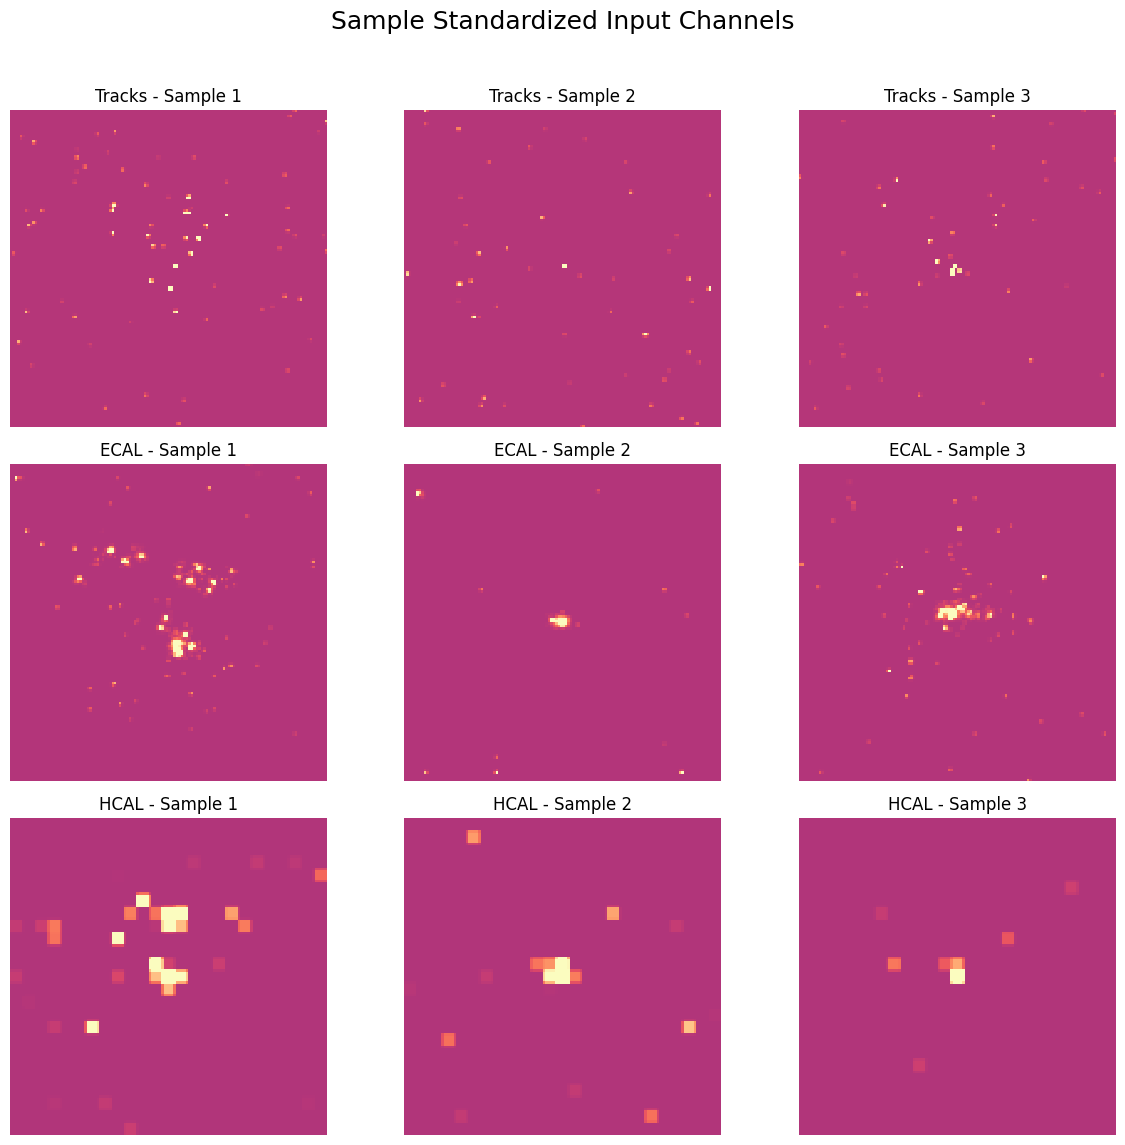

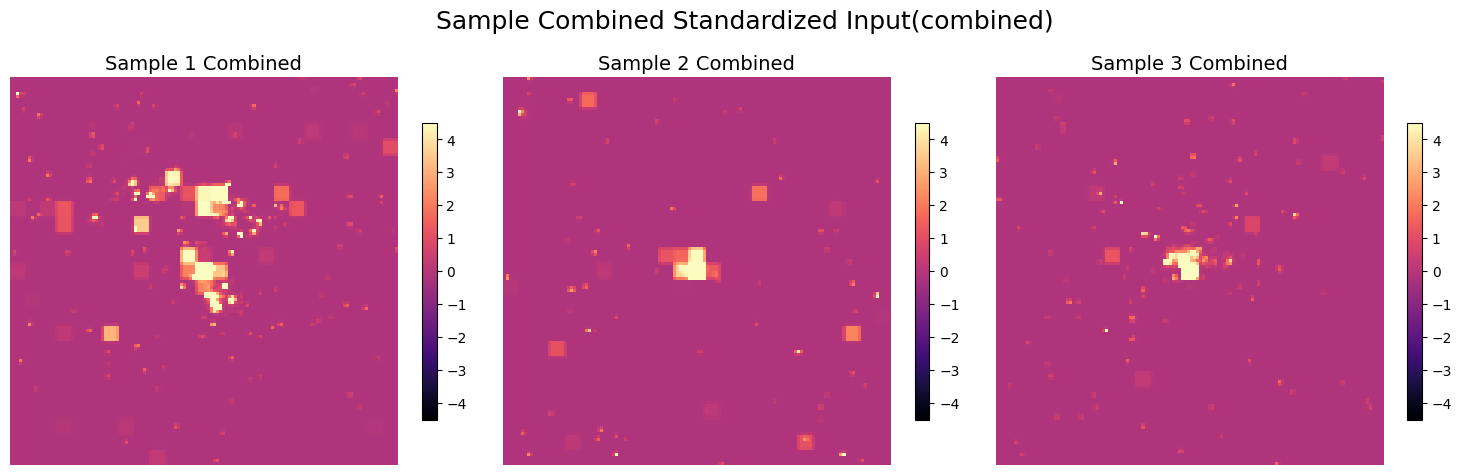

In [ ]:
import matplotlib.pyplot as plt


num_viz_samples = 3
sample_indices = train_indices[:num_viz_samples]
samples_normalized = X_jets_normalized[sample_indices].detach().cpu().numpy()

channel_names = ['Tracks', 'ECAL', 'HCAL']

vmin_std, vmax_std = -3, 3

fig_ch, axs_ch = plt.subplots(nrows=3, ncols=num_viz_samples, figsize=(4 * num_viz_samples, 12))
fig_ch.suptitle('Sample Standardized Input Channels', fontsize=18, y=0.95)

for ch in range(3):
    for i in range(num_viz_samples):
        ax = axs_ch[ch, i]
        img = samples_normalized[i, ch]
        im = ax.imshow(img, cmap='magma', interpolation='nearest', vmin=vmin_std, vmax=vmax_std)
        ax.set_title(f"{channel_names[ch]} - Sample {i+1}", fontsize=12)
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

fig_comb, axs_comb = plt.subplots(nrows=1, ncols=num_viz_samples, figsize=(5 * num_viz_samples, 5))
fig_comb.suptitle('Sample Combined Standardized Input(combined)', fontsize=18, y=0.95)

for i in range(num_viz_samples):
    combined_img = samples_normalized[i].sum(axis=0)
    ax = axs_comb[i]
    im = ax.imshow(combined_img, cmap='magma', interpolation='nearest', vmin=vmin_std * 1.5, vmax=vmax_std * 1.5)
    ax.set_title(f"Sample {i+1} Combined", fontsize=14)
    ax.axis('off')

    cbar = fig_comb.colorbar(im, ax=ax, shrink=0.75)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Encoder: Takes an input image and maps it to the parameters (mean mu and log-variance logvar) of a latent distribution using convolutional layers.
Decoder: Takes a sample z from the latent distribution and reconstructs the image using transposed convolutional layers.
VAE: Combines the Encoder and Decoder. The reparameterize function implements the reparameterization trick, allowing gradients to flow back through the sampling process. The forward method defines the full pass: encode the input, sample from the latent space, and decode to get the reconstruction.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_channels=3, base_filters=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, base_filters, kernel_size=3, stride=2, padding=1) # -> (base_filters, 64, 64)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters*2, kernel_size=3, stride=2, padding=1) # -> (base_filters*2, 32, 32)
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.conv3 = nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, stride=2, padding=1) # -> (base_filters*4, 16, 16)
        self.bn3 = nn.BatchNorm2d(base_filters*4)
        self.conv4 = nn.Conv2d(base_filters*4, base_filters*8, kernel_size=3, stride=2, padding=1) # -> (base_filters*8, 8, 8) # Added layer
        self.bn4 = nn.BatchNorm2d(base_filters*8)

        self.flatten = nn.Flatten()
        flattened_size = base_filters*8 * (RESIZE_DIM // 16) * (RESIZE_DIM // 16)
        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels=3, base_filters=32):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.base_filters = base_filters
        self.unflatten_dim = base_filters*8
        self.unflatten_size = RESIZE_DIM // 16

        self.fc = nn.Linear(latent_dim, self.unflatten_dim * self.unflatten_size * self.unflatten_size)

        self.deconv1 = nn.ConvTranspose2d(self.unflatten_dim, base_filters*4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(base_filters*4)
        self.deconv2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.deconv3 = nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters)
        self.deconv4 = nn.ConvTranspose2d(base_filters, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, self.unflatten_dim, self.unflatten_size, self.unflatten_size)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = self.deconv4(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, input_channels=3, base_filters=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, input_channels, base_filters)
        self.decoder = Decoder(latent_dim, input_channels, base_filters)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

vae = VAE(latent_dim=LATENT_DIM).to(device)
print(vae)

num_params_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters in VAE: {num_params_vae:,}")

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16384, out_features=1024, bias=True)
    (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): 

MSE: Measures how close the reconstructed image (recon_x) is to the original image (x). Mean Squared Error is used here.
KL Divergence (KLD): Acts as a regularizer, encouraging the learned latent distribution (parameterized by mu and logvar) to be close to a standard normal distribution (mean 0, variance 1). The beta parameter controls the weight of the KLD term. The total loss is the sum of these two components, averaged over the batch.

In [ ]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = (MSE + beta * KLD) / x.size(0)
    return total_loss, MSE / x.size(0), KLD / x.size(0)


optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses = []
val_losses = []
val_mse_losses = []
val_kld_losses = []

best_val_loss = float('inf')
best_model_state = None

print("Starting Training...")
for epoch in range(1, NUM_EPOCHS + 1):

    vae.train()
    running_loss = 0.0
    running_mse = 0.0
    running_kld = 0.0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Train]", leave=False)

    for batch in train_pbar:
        imgs = batch[0].to(device)

        optimizer.zero_grad()

        recon, mu, logvar = vae(imgs)


        loss, mse, kld = vae_loss_function(recon, imgs, mu, logvar, beta=BETA_KL)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_mse += mse.item() * imgs.size(0)
        running_kld += kld.item() * imgs.size(0)

        train_pbar.set_postfix(loss=loss.item(), mse=mse.item(), kld=kld.item())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_mse = running_mse / len(train_loader.dataset)
    epoch_train_kld = running_kld / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)


    vae.eval()
    val_running_loss = 0.0
    val_running_mse = 0.0
    val_running_kld = 0.0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [Val]", leave=False)

    with torch.no_grad():
        for batch in val_pbar:
            imgs = batch[0].to(device)
            recon, mu, logvar = vae(imgs)
            loss, mse, kld = vae_loss_function(recon, imgs, mu, logvar, beta=BETA_KL)

            val_running_loss += loss.item() * imgs.size(0)
            val_running_mse += mse.item() * imgs.size(0)
            val_running_kld += kld.item() * imgs.size(0)
            val_pbar.set_postfix(loss=loss.item())

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_mse = val_running_mse / len(val_loader.dataset)
    epoch_val_kld = val_running_kld / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_mse_losses.append(epoch_val_mse)
    val_kld_losses.append(epoch_val_kld)

    print(f"Epoch {epoch:2d}: Train Loss: {epoch_train_loss:.4f} (MSE: {epoch_train_mse:.4f}, KLD: {epoch_train_kld:.4f}) | "
          f"Val Loss: {epoch_val_loss:.4f} (MSE: {epoch_val_mse:.4f}, KLD: {epoch_val_kld:.4f}) | "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")

    scheduler.step(epoch_val_loss)


    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss

        best_model_state = copy.deepcopy(vae.state_dict())
        print(f" *** new best model saved at epoch {epoch} with val Loss: {best_val_loss:.4f} ***")

if best_model_state:
    print(f"Loading best model state from epoch with validation loss: {best_val_loss:.4f}")
    vae.load_state_dict(best_model_state)
else:
    print("using the final model state.")

torch.save(vae.state_dict(), "best_vae_model_weights.pth")


Starting Training...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  1: Train Loss: 40567.4640 (MSE: 40345.3635, KLD: 222.1007) | Val Loss: 26244.2610 (MSE: 26107.8029, KLD: 136.4579) | LR: 1.0e-03
 *** new best model saved at epoch 1 with val Loss: 26244.2610 ***


Epoch 2/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  2: Train Loss: 36306.4218 (MSE: 36161.0533, KLD: 145.3684) | Val Loss: 26789.4866 (MSE: 25908.0735, KLD: 881.4127) | LR: 1.0e-03


Epoch 3/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  3: Train Loss: 39272184461521362944.0000 (MSE: 37974.0730, KLD: 39272184461521346560.0000) | Val Loss: 38418.1576 (MSE: 38002.5169, KLD: 415.6410) | LR: 1.0e-03


Epoch 4/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  4: Train Loss: 60258925343296400.0000 (MSE: 36976.3674, KLD: 60258925343260696.0000) | Val Loss: 39881.1627 (MSE: 37982.6382, KLD: 1898.5247) | LR: 1.0e-03


Epoch 5/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  5: Train Loss: 36271.6964 (MSE: 34988.5145, KLD: 1283.1820) | Val Loss: 28508656512813984771336875016192.0000 (MSE: 704098646851038551098785792.0000, KLD: 28507953362871671540031860768768.0000) | LR: 1.0e-03


Epoch 6/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  6: Train Loss: 1232305176311.4038 (MSE: 34494.2329, KLD: 1232305143241.9883) | Val Loss: 37243.6763 (MSE: 36691.5692, KLD: 552.1074) | LR: 1.0e-03


Epoch 7/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  7: Train Loss: 754891.0724 (MSE: 33742.6544, KLD: 721148.4173) | Val Loss: 25978.2164 (MSE: 25264.8174, KLD: 713.3989) | LR: 1.0e-03
 *** new best model saved at epoch 7 with val Loss: 25978.2164 ***


Epoch 8/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  8: Train Loss: 9432412.6006 (MSE: 33559.4497, KLD: 9398852.9113) | Val Loss: 38713.5062 (MSE: 37993.2571, KLD: 720.2488) | LR: 1.0e-03


Epoch 9/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch  9: Train Loss: 33374.6150 (MSE: 32794.8797, KLD: 579.7354) | Val Loss: 26170.1795 (MSE: 24030.2241, KLD: 2139.9556) | LR: 1.0e-03


Epoch 10/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: Train Loss: 33333.2608 (MSE: 32597.3359, KLD: 735.9250) | Val Loss: 353251.3519 (MSE: 45495.5296, KLD: 307755.8274) | LR: 1.0e-03


Epoch 11/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11: Train Loss: 93505257312.4472 (MSE: 33036.7296, KLD: 93505224917.7781) | Val Loss: inf (MSE: 77462910037623318564624178203328512.0000, KLD: inf) | LR: 1.0e-03


Epoch 12/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12: Train Loss: 3276356267955283.5000 (MSE: 35532.9738, KLD: 3276356267930781.0000) | Val Loss: 1170953112670.4756 (MSE: 13211867.7969, KLD: 1170939928068.3826) | LR: 1.0e-03


Epoch 13/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13: Train Loss: 63853680865579016.0000 (MSE: 34702.5150, KLD: 63853680865547576.0000) | Val Loss: 6088968.2221 (MSE: 40771.6230, KLD: 6048196.6818) | LR: 1.0e-03


Epoch 14/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14: Train Loss: 37790.6105 (MSE: 36293.8610, KLD: 1496.7496) | Val Loss: 40746.4723 (MSE: 39570.4969, KLD: 1175.9752) | LR: 1.0e-04


Epoch 15/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15: Train Loss: 33722.7236 (MSE: 32933.2361, KLD: 789.4874) | Val Loss: 24321.8257 (MSE: 23441.6105, KLD: 880.2151) | LR: 1.0e-04
 *** new best model saved at epoch 15 with val Loss: 24321.8257 ***


Epoch 16/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16: Train Loss: 31593.4631 (MSE: 30906.8033, KLD: 686.6595) | Val Loss: 23244.3560 (MSE: 22365.5345, KLD: 878.8216) | LR: 1.0e-04
 *** new best model saved at epoch 16 with val Loss: 23244.3560 ***


Epoch 17/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17: Train Loss: 30308.7312 (MSE: 29667.4344, KLD: 641.2971) | Val Loss: 22939.7582 (MSE: 22106.6186, KLD: 833.1397) | LR: 1.0e-04
 *** new best model saved at epoch 17 with val Loss: 22939.7582 ***


Epoch 18/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18: Train Loss: 29459.5939 (MSE: 28849.2355, KLD: 610.3580) | Val Loss: 24542.3405 (MSE: 24142.6047, KLD: 399.7356) | LR: 1.0e-04


Epoch 19/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19: Train Loss: 28679.1131 (MSE: 28088.5172, KLD: 590.5956) | Val Loss: 24086.3358 (MSE: 23672.1320, KLD: 414.2038) | LR: 1.0e-04


Epoch 20/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20: Train Loss: 28185.6457 (MSE: 27616.4147, KLD: 569.2309) | Val Loss: 21399.6438 (MSE: 20766.4251, KLD: 633.2189) | LR: 1.0e-04
 *** new best model saved at epoch 20 with val Loss: 21399.6438 ***


Epoch 21/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21: Train Loss: 27889.3191 (MSE: 27331.1239, KLD: 558.1952) | Val Loss: 21722.9702 (MSE: 20952.0344, KLD: 770.9358) | LR: 1.0e-04


Epoch 22/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22: Train Loss: 27504.7193 (MSE: 26948.8408, KLD: 555.8781) | Val Loss: 21498.5722 (MSE: 20773.7759, KLD: 724.7963) | LR: 1.0e-04


Epoch 23/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23: Train Loss: 27134.4630 (MSE: 26599.7803, KLD: 534.6825) | Val Loss: 21171.9118 (MSE: 20395.6500, KLD: 776.2619) | LR: 1.0e-04
 *** new best model saved at epoch 23 with val Loss: 21171.9118 ***


Epoch 24/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24: Train Loss: 26677.8661 (MSE: 26151.8507, KLD: 526.0154) | Val Loss: 21086.3605 (MSE: 20341.8657, KLD: 744.4948) | LR: 1.0e-04
 *** new best model saved at epoch 24 with val Loss: 21086.3605 ***


Epoch 25/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25: Train Loss: 26428.2833 (MSE: 25919.0935, KLD: 509.1899) | Val Loss: 20984.1723 (MSE: 20484.3905, KLD: 499.7817) | LR: 1.0e-04
 *** new best model saved at epoch 25 with val Loss: 20984.1723 ***


Epoch 26/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26: Train Loss: 26237.9133 (MSE: 25731.2324, KLD: 506.6806) | Val Loss: 20390.3310 (MSE: 19837.0426, KLD: 553.2883) | LR: 1.0e-04
 *** new best model saved at epoch 26 with val Loss: 20390.3310 ***


Epoch 27/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27: Train Loss: 25979.6054 (MSE: 25485.5967, KLD: 494.0087) | Val Loss: 21246.5824 (MSE: 20521.8836, KLD: 724.6986) | LR: 1.0e-04


Epoch 28/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28: Train Loss: 25825.8402 (MSE: 25333.5641, KLD: 492.2763) | Val Loss: 21135.7873 (MSE: 20719.0361, KLD: 416.7510) | LR: 1.0e-04


Epoch 29/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29: Train Loss: 25524.9469 (MSE: 25040.5609, KLD: 484.3862) | Val Loss: 22698.2282 (MSE: 21739.9799, KLD: 958.2482) | LR: 1.0e-04


Epoch 30/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30: Train Loss: 25277.6655 (MSE: 24809.8933, KLD: 467.7723) | Val Loss: 20667.5700 (MSE: 20204.3923, KLD: 463.1775) | LR: 1.0e-04


Epoch 31/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 31: Train Loss: 25123.6426 (MSE: 24656.5768, KLD: 467.0657) | Val Loss: 20389.8418 (MSE: 19906.6048, KLD: 483.2371) | LR: 1.0e-04
 *** new best model saved at epoch 31 with val Loss: 20389.8418 ***


Epoch 32/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32: Train Loss: 24802.8438 (MSE: 24340.7343, KLD: 462.1095) | Val Loss: 20607.1075 (MSE: 19809.7537, KLD: 797.3538) | LR: 1.0e-04


Epoch 33/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33: Train Loss: 24759.5853 (MSE: 24304.2837, KLD: 455.3018) | Val Loss: 23464.0522 (MSE: 23198.2413, KLD: 265.8109) | LR: 1.0e-05


Epoch 34/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34: Train Loss: 24520.6233 (MSE: 24063.0555, KLD: 457.5680) | Val Loss: 20511.2137 (MSE: 19524.2462, KLD: 986.9674) | LR: 1.0e-05


Epoch 35/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35: Train Loss: 24554.5285 (MSE: 24100.1401, KLD: 454.3887) | Val Loss: 20205.1096 (MSE: 19539.4077, KLD: 665.7018) | LR: 1.0e-05
 *** new best model saved at epoch 35 with val Loss: 20205.1096 ***


Epoch 36/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 36: Train Loss: 24494.3904 (MSE: 24038.9241, KLD: 455.4661) | Val Loss: 20416.6769 (MSE: 19996.2030, KLD: 420.4740) | LR: 1.0e-05


Epoch 37/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37: Train Loss: 24677.4257 (MSE: 24220.1793, KLD: 457.2463) | Val Loss: 20339.4813 (MSE: 19761.1623, KLD: 578.3188) | LR: 1.0e-05


Epoch 38/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38: Train Loss: 24477.8692 (MSE: 24024.0912, KLD: 453.7779) | Val Loss: 20602.1232 (MSE: 20224.7935, KLD: 377.3295) | LR: 1.0e-05


Epoch 39/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39: Train Loss: 24464.6329 (MSE: 24012.5266, KLD: 452.1063) | Val Loss: 20456.2525 (MSE: 19364.3164, KLD: 1091.9360) | LR: 1.0e-05


Epoch 40/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40: Train Loss: 24415.6417 (MSE: 23964.0927, KLD: 451.5490) | Val Loss: 21353.0321 (MSE: 20544.6591, KLD: 808.3730) | LR: 1.0e-05


Epoch 41/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 41: Train Loss: 24345.4301 (MSE: 23894.8098, KLD: 450.6202) | Val Loss: 21445.5161 (MSE: 21130.4599, KLD: 315.0562) | LR: 1.0e-05


Epoch 42/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42: Train Loss: 24329.5532 (MSE: 23879.4284, KLD: 450.1249) | Val Loss: 20037.5966 (MSE: 19586.6492, KLD: 450.9473) | LR: 1.0e-06
 *** new best model saved at epoch 42 with val Loss: 20037.5966 ***


Epoch 43/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43: Train Loss: 24528.3127 (MSE: 24078.4134, KLD: 449.8994) | Val Loss: 20122.9965 (MSE: 19614.7259, KLD: 508.2706) | LR: 1.0e-06


Epoch 44/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44: Train Loss: 24369.2845 (MSE: 23919.3505, KLD: 449.9338) | Val Loss: 20195.1851 (MSE: 19578.9816, KLD: 616.2033) | LR: 1.0e-06


Epoch 45/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45: Train Loss: 24328.7303 (MSE: 23877.8281, KLD: 450.9018) | Val Loss: 20529.5042 (MSE: 19390.0946, KLD: 1139.4095) | LR: 1.0e-06


Epoch 46/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 46: Train Loss: 24357.0404 (MSE: 23907.8433, KLD: 449.1970) | Val Loss: 20372.1263 (MSE: 19970.9621, KLD: 401.1640) | LR: 1.0e-06


Epoch 47/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47: Train Loss: 24517.5047 (MSE: 24068.1214, KLD: 449.3831) | Val Loss: 20040.6506 (MSE: 19452.6586, KLD: 587.9921) | LR: 1.0e-06


Epoch 48/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48: Train Loss: 24345.4086 (MSE: 23895.6952, KLD: 449.7134) | Val Loss: 21076.8695 (MSE: 20370.1978, KLD: 706.6719) | LR: 1.0e-06


Epoch 49/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49: Train Loss: 24293.8566 (MSE: 23845.0577, KLD: 448.7991) | Val Loss: 19960.9859 (MSE: 19405.1277, KLD: 555.8584) | LR: 1.0e-07
 *** new best model saved at epoch 49 with val Loss: 19960.9859 ***


Epoch 50/50 [Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50: Train Loss: 24305.6181 (MSE: 23856.4898, KLD: 449.1280) | Val Loss: 20325.9273 (MSE: 19886.2924, KLD: 439.6347) | LR: 1.0e-07
Loading best model state from epoch with validation loss: 19960.9859


In [ ]:
NUM_RECON_SAMPLES=3
FIG_SIZE_CHANNEL = (5 * num_viz_samples, 16)
FIG_SIZE_COMBINED = (5 * num_viz_samples, 16)
vae.eval()
vmin_plot, vmax_plot = -3, 3
val_indices_subset = np.random.choice(len(val_dataset), NUM_RECON_SAMPLES, replace=False)
sample_data = torch.stack([val_dataset[i][0] for i in val_indices_subset]).to(device)

with torch.no_grad():
    reconstructed_data, _, _ = vae(sample_data)

original_images_np = sample_data.cpu().numpy().transpose(0, 2, 3, 1)
reconstructed_images_np = reconstructed_data.cpu().numpy().transpose(0, 2, 3, 1)

channel_names = ['ECAL', 'HCAL', 'Tracks']

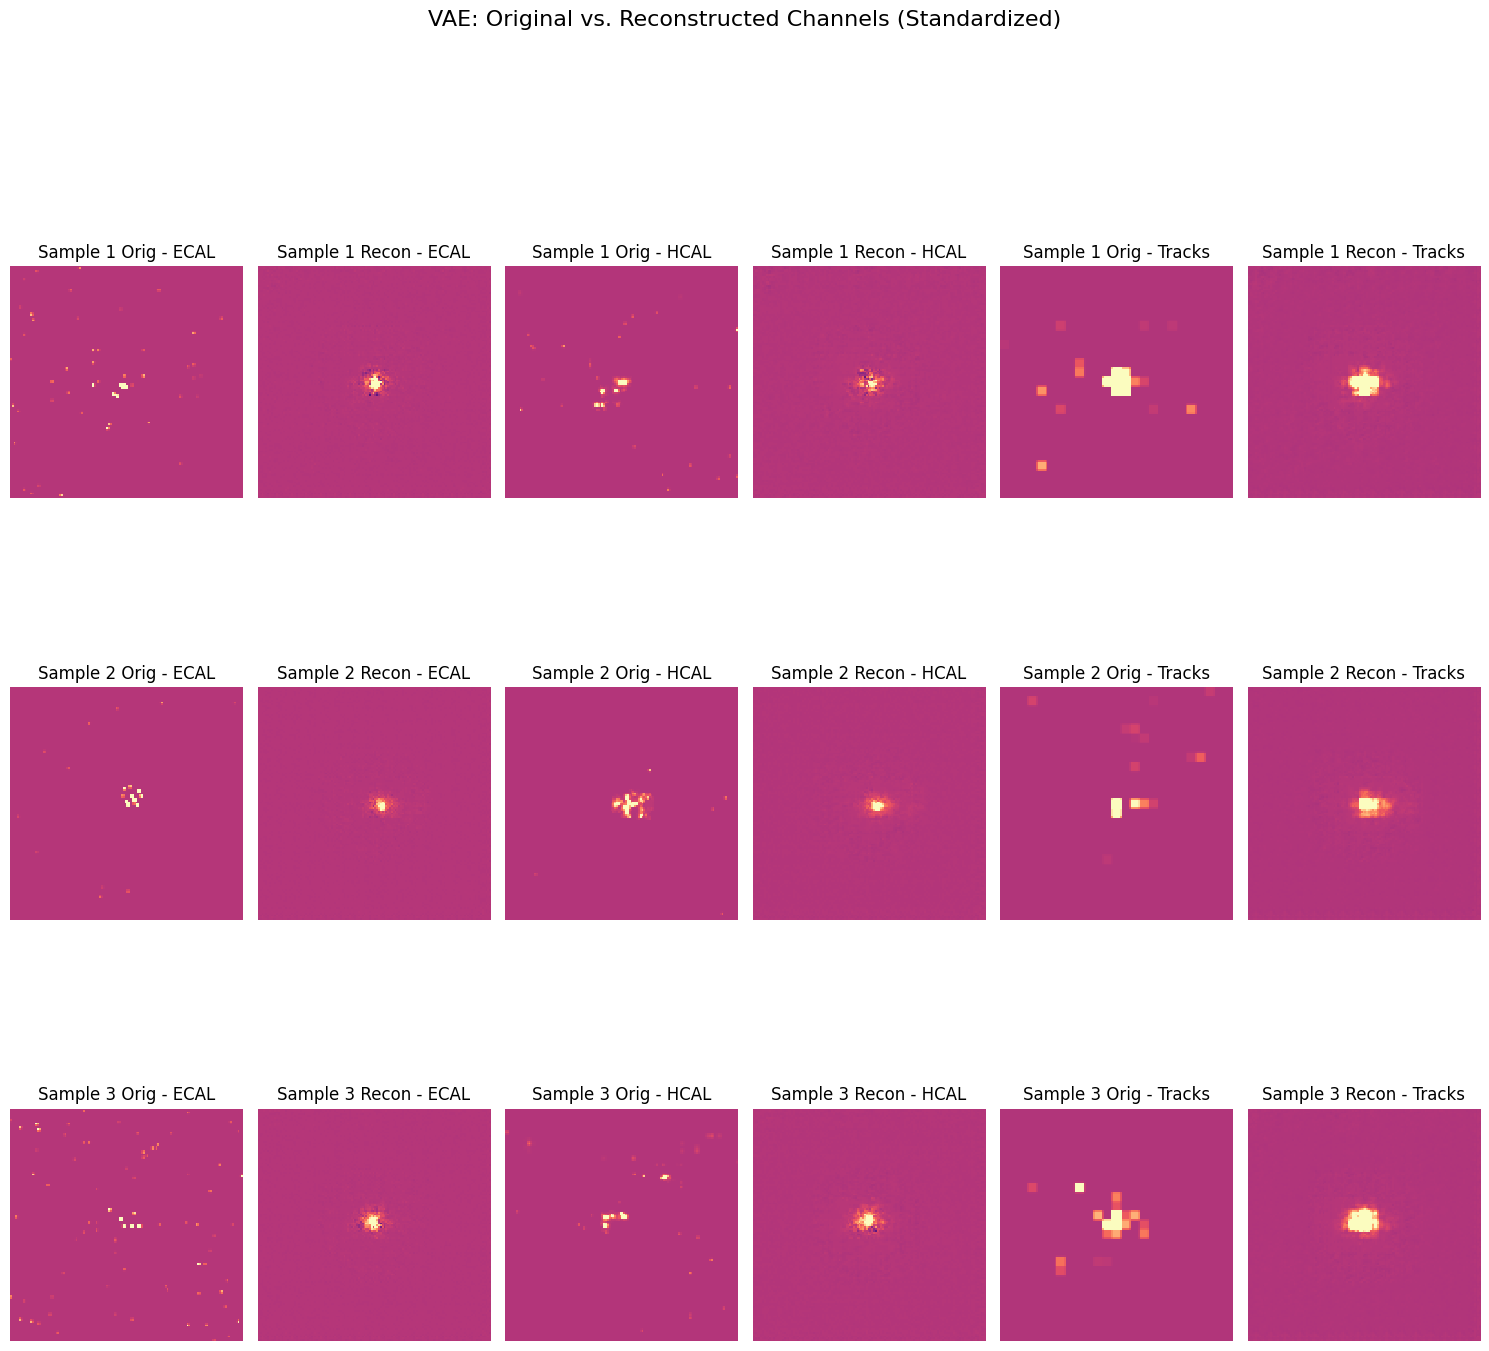

In [ ]:
fig_ch_recon_vae, axs_ch_recon_vae = plt.subplots(NUM_RECON_SAMPLES, 3 * 2, figsize=FIG_SIZE_CHANNEL)
fig_ch_recon_vae.suptitle('VAE: Original vs. Reconstructed Channels (Standardized)', fontsize=16)

for i in range(NUM_RECON_SAMPLES):
    for ch in range(3):
        col_idx = ch * 2
        ax_orig = axs_ch_recon_vae[i, col_idx] if NUM_RECON_SAMPLES > 1 else axs_ch_recon_vae[col_idx]
        im_orig = ax_orig.imshow(original_images_np[i, :, :, ch], cmap='magma', interpolation='nearest', vmin=vmin_plot, vmax=vmax_plot)
        ax_orig.set_title(f"Sample {i+1} Orig - {channel_names[ch]}")
        ax_orig.axis('off')

        ax_recon = axs_ch_recon_vae[i, col_idx + 1] if NUM_RECON_SAMPLES > 1 else axs_ch_recon_vae[col_idx + 1]
        im_recon = ax_recon.imshow(reconstructed_images_np[i, :, :, ch], cmap='magma', interpolation='nearest', vmin=vmin_plot, vmax=vmax_plot)
        ax_recon.set_title(f"Sample {i+1} Recon - {channel_names[ch]}")
        ax_recon.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

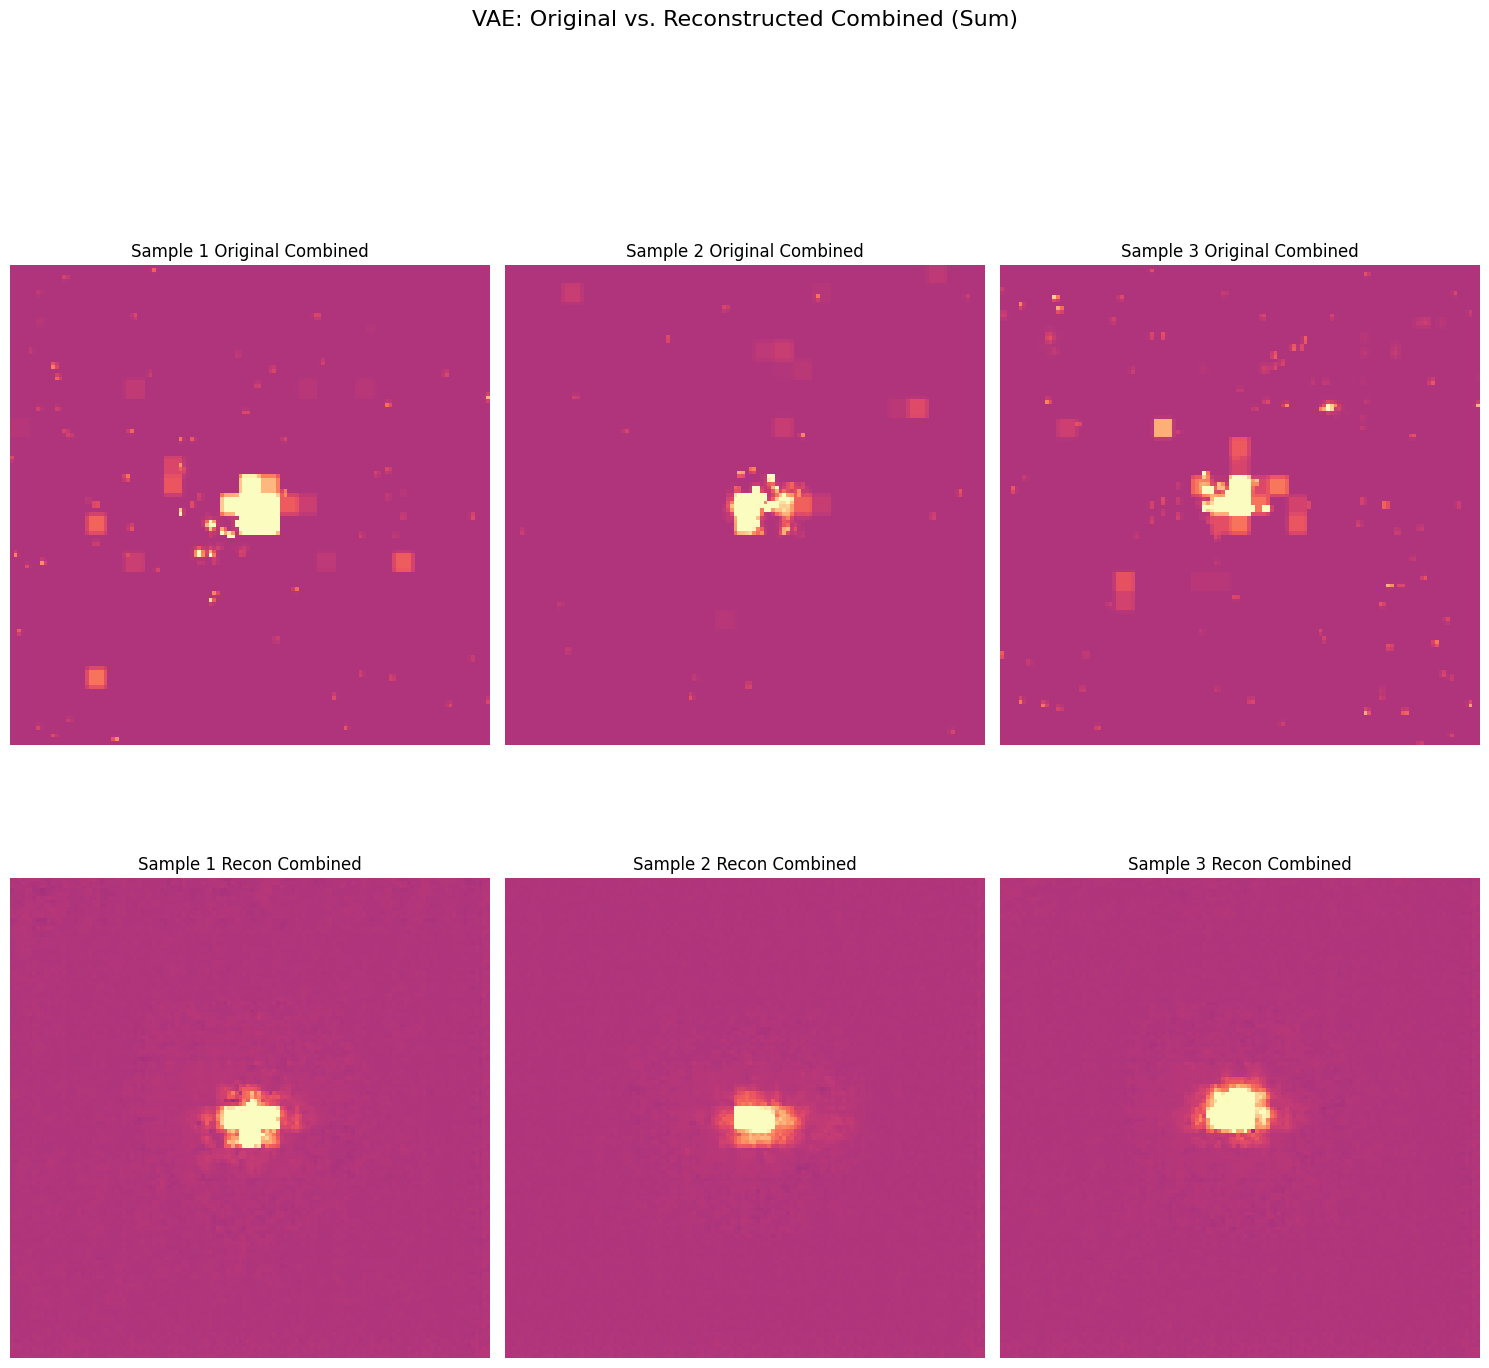

In [ ]:
fig_comb_recon_vae, axs_comb_recon_vae = plt.subplots(2, NUM_RECON_SAMPLES, figsize=FIG_SIZE_COMBINED)
fig_comb_recon_vae.suptitle('VAE: Original vs. Reconstructed Combined (Sum)', fontsize=16)
vmin_comb_plot, vmax_comb_plot = vmin_plot * 1.5, vmax_plot * 1.5

for i in range(NUM_RECON_SAMPLES):
    combined_orig = original_images_np[i].sum(axis=2)
    combined_recon = reconstructed_images_np[i].sum(axis=2)

    ax_orig = axs_comb_recon_vae[0, i]
    im_orig = ax_orig.imshow(combined_orig, cmap='magma', interpolation='nearest', vmin=vmin_comb_plot, vmax=vmax_comb_plot)
    ax_orig.set_title(f"Sample {i+1} Original Combined")
    ax_orig.axis('off')

    ax_recon = axs_comb_recon_vae[1, i]
    im_recon = ax_recon.imshow(combined_recon, cmap='magma', interpolation='nearest', vmin=vmin_comb_plot, vmax=vmax_comb_plot)
    ax_recon.set_title(f"Sample {i+1} Recon Combined")
    ax_recon.axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

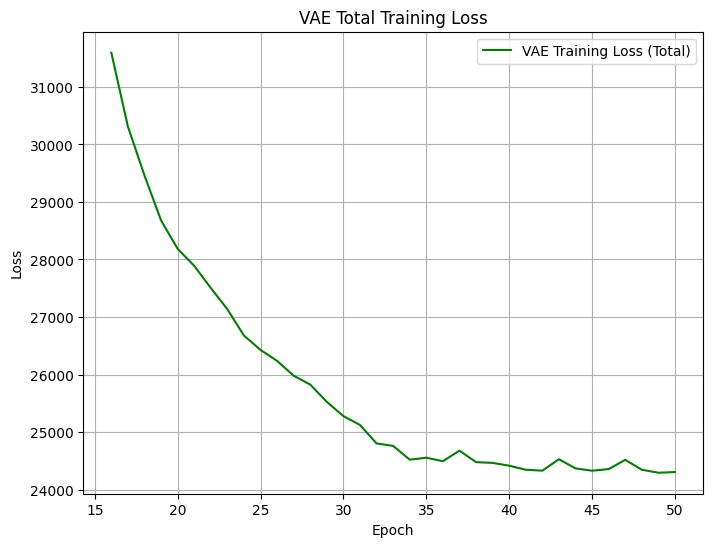

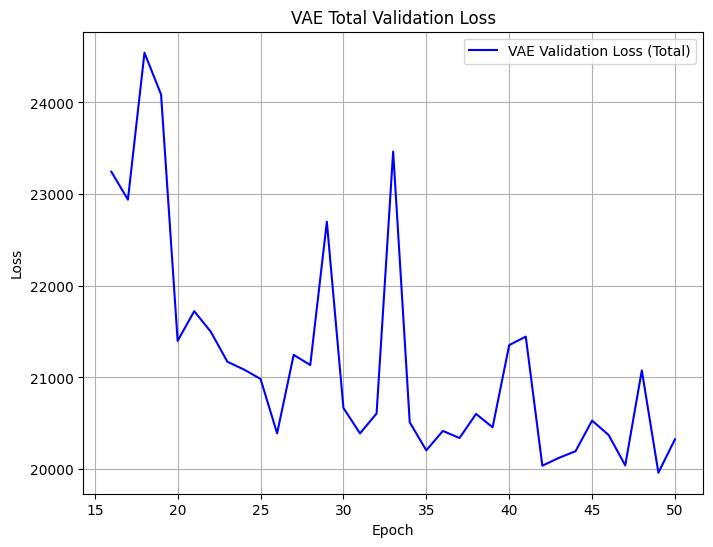

In [ ]:

plot = list(range(1, len(train_losses) + 1))[15:]
plt.figure(figsize=(8, 6))
plt.plot(plot, train_losses[15:], 'g', label='VAE Training Loss (Total)')
plt.title('VAE Total Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Plot = list(range(1, len(train_losses) + 1))[15:]
plt.figure(figsize=(8, 6))
plt.plot(Plot, val_losses[15:], 'b', label='VAE Validation Loss (Total)')
plt.title('VAE Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


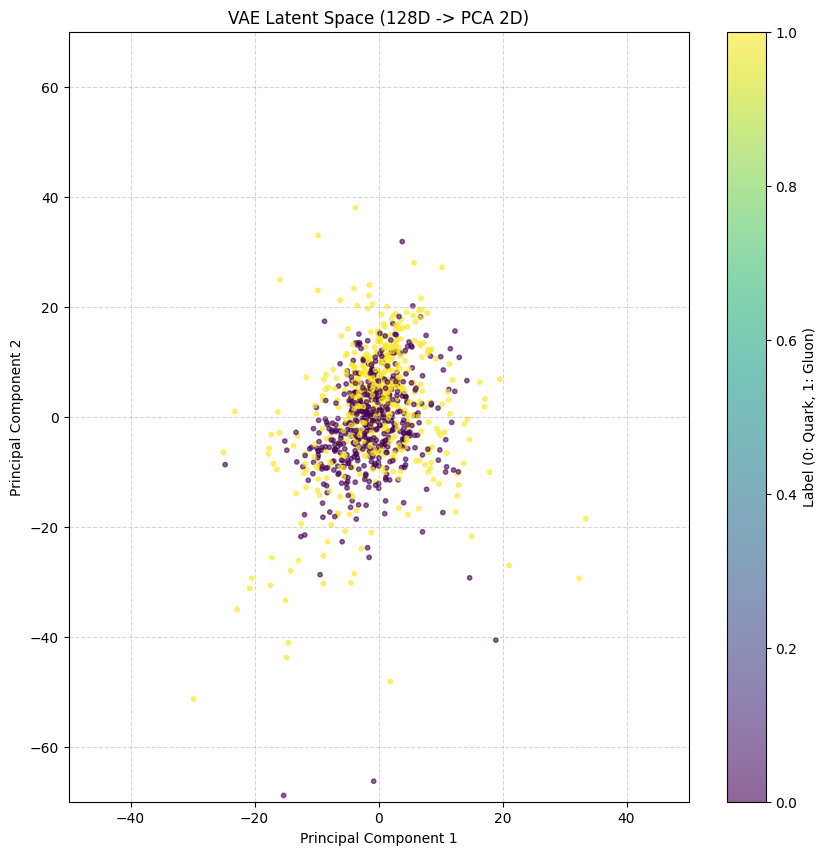

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

if 'labels_for_plot' not in locals():
    labels_for_plot = None

plt.figure(figsize=FIG_SIZE_LATENT)

if LATENT_DIM == 2:

    scatter = plt.scatter(latent_mus[:, 0], latent_mus[:, 1],
                          c=labels_for_plot, cmap='viridis', alpha=0.6, s=10)
    plt.xlabel('Latent Dimension 1 (mu)')
    plt.ylabel('Latent Dimension 2 (mu)')
    title = 'VAE Latent Space (2D)'

else:

    pca = PCA(n_components=2)
    latent_mus_flat = latent_mus.reshape(latent_mus.shape[0], -1)
    latent_mus_pca = pca.fit_transform(latent_mus_flat)
    scatter = plt.scatter(latent_mus_pca[:, 0], latent_mus_pca[:, 1],
                          c=labels_for_plot, cmap='viridis', alpha=0.6, s=10)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    title = f'VAE Latent Space ({LATENT_DIM}D -> PCA 2D)'

    plt.xlim(-50, 50)
    plt.ylim(-70, 70)


if labels_for_plot is not None:

    cbar = plt.colorbar(scatter, label='Label (0: Quark, 1: Gluon)')
plt.title(title)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()